In [74]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans

cities = pd.read_csv(f'./livingwage.csv') # you might need to change this path
cities = cities.dropna()
cities.head()

,rank_2020,city,state,population_2020,population_2010,land_area_sqmi,density,one_adult_no_kids_living_wage,one_adult_one_kid_living_wage,one_adult_two_kids_living_wage,one_adult_three_kids_living_wage,two_adults_one_working_no_kids_living_wage,two_adults_one_working_one_kid_living_wage,two_adults_one_working_two_kids_living_wage,two_adults_one_working_three_kids_living_wage,two_adults_both_working_no_kids_living_wage,two_adults_both_working_one_kid_living_wage,two_adults_both_working_two_kids_living_wage,two_adults_both_working_three_kids_living_wage
0,1,New York,New York,8804190,8175133,300.5,29298,20.00,38.99,49.18,64.30,29.16,34.35,38.13,42.42,14.03,20.95,26.53,32.40
1,2,Los Angeles,California,3898747,3792621,469.5,8304,19.22,41.55,51.30,67.56,31.01,37.96,41.94,47.75,14.62,22.36,27.73,34.01
2,3,Chicago,Illinois,2746388,2695598,227.7,12061,16.08,32.25,40.20,51.69,25.41,29.73,33.38,35.93,12.28,17.52,22.01,25.94
3,4,Houston,Texas,2304580,2099451,640.4,3599,14.29,29.09,35.73,46.02,22.88,27.54,30.93,33.69,11.14,15.85,19.63,23.09
4,5,Phoenix,Arizona,1608139,1445632,518.0,3105,15.41,29.44,35.40,46.01,24.85,29.25,32.98,36.95,12.03,16.21,19.65,23.23


In [75]:
salaries = pd.read_csv(f'./cp_major_sal (1).csv') # you might need to change this path
salaries = salaries.dropna()
salaries.head()

,Field of Study,Employment Rate,Median Debt,Median Salary,Salary Score,Degree Type
0,"Aerospace, Aeronautical and Astronautical Engi...",95%,"$22,410","$76,020",98,B
1,Agricultural Business and Management,97%,"$18,390","$56,190",96,B
2,Agricultural Engineering,100%,"$20,000","$63,010",85,B
3,Agricultural Public Services,100%,Not Reported,"$41,300",72,B
4,"Agriculture, General",96%,"$13,000","$49,640",97,B


In [76]:
# Assuming work 40 hours a week, 52 weeks a year for the conversion (which is a massive over-simplification but I think the best we can do to approximate)
import locale
locale.setlocale(locale.LC_ALL,'')
salaries['med-hourly'] = salaries['Median Salary'].replace('[\$,]', '', regex=True).astype(float)
salaries['med-hourly'] = salaries['med-hourly'] / (40 * 52)
# Remove the higher than bachelors
salaries = salaries[salaries['Degree Type'] == 'B']
salaries.columns = ['field-study', 'employment-rate', 'med-debt', 'med-salary', 'salary-score', 'degree-type', 'med-hourly']
salaries.head()

,field-study,employment-rate,med-debt,med-salary,salary-score,degree-type,med-hourly
0,"Aerospace, Aeronautical and Astronautical Engi...",95%,"$22,410","$76,020",98,B,36.548077
1,Agricultural Business and Management,97%,"$18,390","$56,190",96,B,27.014423
2,Agricultural Engineering,100%,"$20,000","$63,010",85,B,30.293269
3,Agricultural Public Services,100%,Not Reported,"$41,300",72,B,19.855769
4,"Agriculture, General",96%,"$13,000","$49,640",97,B,23.865385


What I'd like to do is do a join based on a major's salary being greater than the living wage (basically matching each major to a city they can live in)

In [77]:
cities.dtypes

rank_2020                                           int64
city                                               object
state                                              object
population_2020                                     int64
population_2010                                     int64
land_area_sqmi                                    float64
density                                             int64
one_adult_no_kids_living_wage                     float64
one_adult_one_kid_living_wage                     float64
one_adult_two_kids_living_wage                    float64
one_adult_three_kids_living_wage                  float64
two_adults_one_working_no_kids_living_wage        float64
two_adults_one_working_one_kid_living_wage        float64
two_adults_one_working_two_kids_living_wage       float64
two_adults_one_working_three_kids_living_wage     float64
two_adults_both_working_no_kids_living_wage       float64
two_adults_both_working_one_kid_living_wage       float64
two_adults_bot

In [78]:
salaries.dtypes

field-study         object
employment-rate     object
med-debt            object
med-salary          object
salary-score        object
degree-type         object
med-hourly         float64
dtype: object

In [185]:
combo = cities.merge(salaries[['field-study', 'med-hourly']], how='cross')
combo = combo[combo['one_adult_no_kids_living_wage'] < combo['med-hourly']]
combo.head()

,rank_2020,city,state,population_2020,population_2010,land_area_sqmi,density,one_adult_no_kids_living_wage,one_adult_one_kid_living_wage,one_adult_two_kids_living_wage,...,two_adults_one_working_no_kids_living_wage,two_adults_one_working_one_kid_living_wage,two_adults_one_working_two_kids_living_wage,two_adults_one_working_three_kids_living_wage,two_adults_both_working_no_kids_living_wage,two_adults_both_working_one_kid_living_wage,two_adults_both_working_two_kids_living_wage,two_adults_both_working_three_kids_living_wage,field-study,med-hourly
0,1,New York,New York,8804190,8175133,300.5,29298,20.0,38.99,49.18,...,29.16,34.35,38.13,42.42,14.03,20.95,26.53,32.4,"Aerospace, Aeronautical and Astronautical Engi...",36.548077
1,1,New York,New York,8804190,8175133,300.5,29298,20.0,38.99,49.18,...,29.16,34.35,38.13,42.42,14.03,20.95,26.53,32.4,Agricultural Business and Management,27.014423
2,1,New York,New York,8804190,8175133,300.5,29298,20.0,38.99,49.18,...,29.16,34.35,38.13,42.42,14.03,20.95,26.53,32.4,Agricultural Engineering,30.293269
4,1,New York,New York,8804190,8175133,300.5,29298,20.0,38.99,49.18,...,29.16,34.35,38.13,42.42,14.03,20.95,26.53,32.4,"Agriculture, General",23.865385
6,1,New York,New York,8804190,8175133,300.5,29298,20.0,38.99,49.18,...,29.16,34.35,38.13,42.42,14.03,20.95,26.53,32.4,Architectural Engineering,32.365385


In [186]:
combo = combo.set_index(['city', 'state', 'field-study'])
combo.head()

rank_2020  \
city     state    field-study                                                     
New York New York Aerospace, Aeronautical and Astronautical Engin...          1   
                  Agricultural Business and Management                        1   
                  Agricultural Engineering                                    1   
                  Agriculture, General                                        1   
                  Architectural Engineering                                   1   

                                                                      population_2020  \
city     state    field-study                                                           
New York New York Aerospace, Aeronautical and Astronautical Engin...          8804190   
                  Agricultural Business and Management                        8804190   
                  Agricultural Engineering                                    8804190   
                  Agriculture, General                                        8804190   
                  Architectural Engineering                                   8804190   

                                                                      population_2010  \
city     state    field-study                                                           
New York New York Aerospace, Aeronautical and Astronautical Engin...          8175133   
                  Agricultural Business and Management                        8175133   
                  Agricultural Engineering                                    8175133   
                  Agriculture, General                                        8175133   
                  Architectural Engineering                                   8175133   

                                                                      land_area_sqmi  \
city     state    field-study                                                          
New York New York Aerospace, Aeronautical and Astronautical Engin...           300.5   
                  Agricultural Business and Management                         300.5   
                  Agricultural Engineering                                     300.5   
                  Agriculture, General                                         300.5   
                  Architectural Engineering                                    300.5   

                                                                      density  \
city     state    field-study                                                   
New York New York Aerospace, Aeronautical and Astronautical Engin...    29298   
                  Agricultural Business and Management                  29298   
                  Agricultural Engineering                              29298   
                  Agriculture, General                                  29298   
                  Architectural Engineering                             29298   

                                                                      one_adult_no_kids_living_wage  \
city     state    field-study                                                                         
New York New York Aerospace, Aeronautical and Astronautical Engin...                           20.0   
                  Agricultural Business and Management                                         20.0   
                  Agricultural Engineering                                                     20.0   
                  Agriculture, General                                                         20.0   
                  Architectural Engineering                                                    20.0   

                                                                      one_adult_one_kid_living_wage  \
city     state    field-study                                                                         
New York New York Aerospace, Aeronautical and Astronautical Engin...                          38.99   
                  Agricu

In [187]:
df = combo.drop(["rank_2020"], axis=1)
df.head()

population_2020  \
city     state    field-study                                                           
New York New York Aerospace, Aeronautical and Astronautical Engin...          8804190   
                  Agricultural Business and Management                        8804190   
                  Agricultural Engineering                                    8804190   
                  Agriculture, General                                        8804190   
                  Architectural Engineering                                   8804190   

                                                                      population_2010  \
city     state    field-study                                                           
New York New York Aerospace, Aeronautical and Astronautical Engin...          8175133   
                  Agricultural Business and Management                        8175133   
                  Agricultural Engineering                                    8175133   
                  Agriculture, General                                        8175133   
                  Architectural Engineering                                   8175133   

                                                                      land_area_sqmi  \
city     state    field-study                                                          
New York New York Aerospace, Aeronautical and Astronautical Engin...           300.5   
                  Agricultural Business and Management                         300.5   
                  Agricultural Engineering                                     300.5   
                  Agriculture, General                                         300.5   
                  Architectural Engineering                                    300.5   

                                                                      density  \
city     state    field-study                                                   
New York New York Aerospace, Aeronautical and Astronautical Engin...    29298   
                  Agricultural Business and Management                  29298   
                  Agricultural Engineering                              29298   
                  Agriculture, General                                  29298   
                  Architectural Engineering                             29298   

                                                                      one_adult_no_kids_living_wage  \
city     state    field-study                                                                         
New York New York Aerospace, Aeronautical and Astronautical Engin...                           20.0   
                  Agricultural Business and Management                                         20.0   
                  Agricultural Engineering                                                     20.0   
                  Agriculture, General                                                         20.0   
                  Architectural Engineering                                                    20.0   

                                                                      one_adult_one_kid_living_wage  \
city     state    field-study                                                                         
New York New York Aerospace, Aeronautical and Astronautical Engin...                          38.99   
                  Agricultural Business and Management                                        38.99   
                  Agricultural Engineering                                                    38.99   
                  Agriculture, General                                                        38.99   
                  Architectural Engineering                                                   38.99   

                                                                      one_adult_two_kids_living_wage  \
city     state    field-study                                                            

In [188]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(df),columns=df.columns)
X

,population_2020,population_2010,land_area_sqmi,density,one_adult_no_kids_living_wage,one_adult_one_kid_living_wage,one_adult_two_kids_living_wage,one_adult_three_kids_living_wage,two_adults_one_working_no_kids_living_wage,two_adults_one_working_one_kid_living_wage,two_adults_one_working_two_kids_living_wage,two_adults_one_working_three_kids_living_wage,two_adults_both_working_no_kids_living_wage,two_adults_both_working_one_kid_living_wage,two_adults_both_working_two_kids_living_wage,two_adults_both_working_three_kids_living_wage,med-hourly
0,9.551194,9.463002,0.540107,6.578376,1.974201,1.544227,1.640495,1.569891,1.443897,1.250600,1.244913,1.135258,1.382726,1.522014,1.617516,1.582803,1.158545
1,9.551194,9.463002,0.540107,6.578376,1.974201,1.544227,1.640495,1.569891,1.443897,1.250600,1.244913,1.135258,1.382726,1.522014,1.617516,1.582803,0.063122
2,9.551194,9.463002,0.540107,6.578376,1.974201,1.544227,1.640495,1.569891,1.443897,1.250600,1.244913,1.135258,1.382726,1.522014,1.617516,1.582803,0.439864
3,9.551194,9.463002,0.540107,6.578376,1.974201,1.544227,1.640495,1.569891,1.443897,1.250600,1.244913,1.135258,1.382726,1.522014,1.617516,1.582803,-0.298705
4,9.551194,9.463002,0.540107,6.578376,1.974201,1.544227,1.640495,1.569891,1.443897,1.250600,1.244913,1.135258,1.382726,1.522014,1.617516,1.582803,0.677951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4432,-0.455905,-0.452184,-0.586946,-0.181130,0.226301,-0.203164,-0.239486,-0.296797,-0.117707,-0.160329,-0.163692,-0.253284,0.037995,-0.210509,-0.243423,-0.308698,-1.104114
4433,-0.455905,-0.452184,-0.586946,-0.181130,0.226301,-0.203164,-0.239486,-0.296797,-0.117707,-0.160329,-0.163692,-0.253284,0.037995,-0.210509,-0.243423,-0.308698,-0.271084
4434,-0.455905,-0.452184,-0.586946,-0.181130,0.226301,-0.203164,-0.239486,-0.296797,-0.117707,-0.160329,-0.163692,-0.253284,0.037995,-0.210509,-0.243423,-0.308698,-0.925687
4435,-0.455905,-0.452184,-0.586946,-0.181130,0.226301,-0.203164,-0.239486,-0.296797,-0.117707,-0.160329,-0.163692,-0.253284,0.037995,-0.210509,-0.243423,-0.308698,-0.387090


,0,1
0,7.385485,13.848617
1,7.319265,13.849088
2,7.342039,13.848926
3,7.297391,13.849243
4,7.356432,13.848823
...,...,...
4432,-0.669725,-0.703501
4433,-0.619366,-0.703860
4434,-0.658938,-0.703578
4435,-0.626379,-0.703810


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


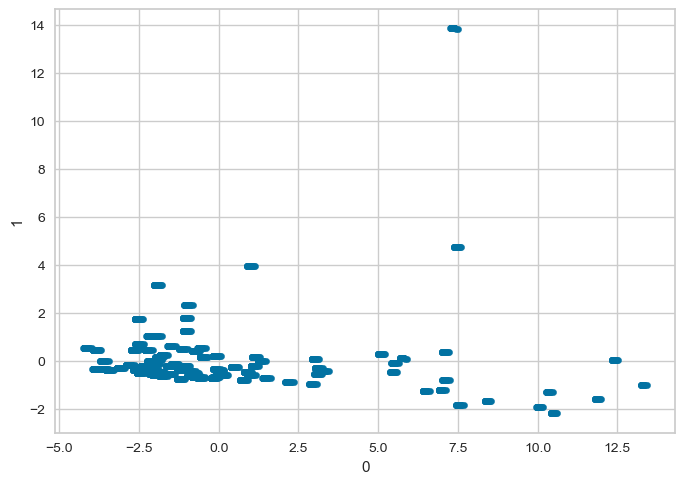

In [189]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
X_pca = pd.DataFrame(X_pca)
display(X_pca)
X_pca.plot.scatter(x=X_pca.columns[0],y=X_pca.columns[1]);

In [190]:
kmeans = KMeans(n_clusters=3).fit(X)

In [191]:
cluster_labels = {}
# Are we doing 1 indexing now?
cluster_labels[3] = kmeans.predict(X)
cluster_labels = pd.DataFrame(cluster_labels)

<AxesSubplot:xlabel='PCA Component 0', ylabel='PCA Component 1'>

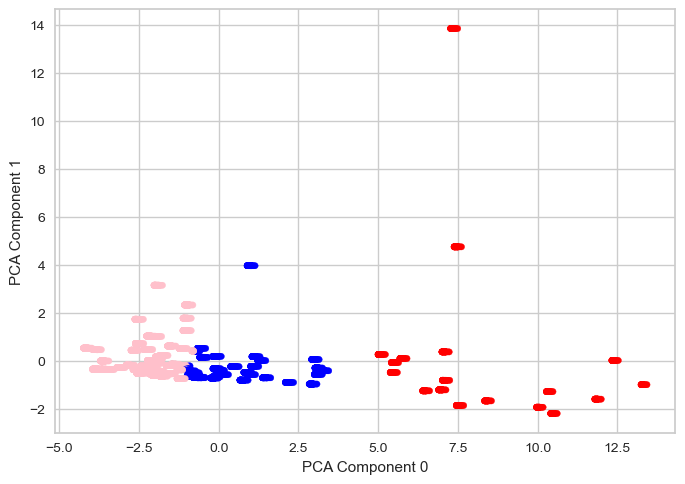

In [192]:
colorings = {}
# colorings[2] = cluster_labels[2].map({0: "Blue", 1: "Red"}) # This is a new pandas command for us that maps all 0 values to Blue, etc
colorings[3] = cluster_labels[3].map({0: "Blue", 1: "Red",2: "Pink"}) # This is a new pandas command for us that maps all 0 values to Blue, etc
# X_pca.plot.scatter(x=X_pca.columns[0],y=X_pca.columns[1],c=colorings[2])
X_pca.plot.scatter(x=X_pca.columns[0],y=X_pca.columns[1],c=colorings[3], xlabel='PCA Component 0', ylabel='PCA Component 1')

In [168]:
from sklearn.metrics import silhouette_score
silhouette_score(X, cluster_labels[3])

0.30941564936415966

In [179]:
from sklearn.metrics import silhouette_samples

s_df = pd.DataFrame()

s_df[3] = silhouette_samples(X, cluster_labels[3])
s_df.index.name="i"
s_df = s_df.reset_index()
# display(s_df)
# s_df.sort_values(by=[3]).plot(kind='hist')

source = s_df.melt(id_vars=["i"])
source.columns = ["i","k","s"]
# display(source)

import altair as alt
# alt.renderers.enable('mimetype')
alt.renderers.enable('default')
alt.Chart(source).mark_bar().encode(
    x = "s:Q",
    y = alt.Y("i:N",sort='x',axis=alt.Axis(labels=False)),
    row = "k:N",
    color = "k:N"
).resolve_scale(y='independent').properties(height=200)

# alt.Chart(s.reset_index()).mark_line().encode(
#     x='index:T',
#     y='sil:Q'
# )


/home/claire/.local/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

In [87]:
cluster_labels[3]

0       2
1       2
2       2
3       2
4       2
       ..
4432    1
4433    1
4434    1
4435    1
4436    1
Name: 3, Length: 4437, dtype: int32

In [193]:
df = combo.reset_index()[['city','state','field-study']]
df['label']  = cluster_labels[3]
df['label'].value_counts()

2    2258
0    1632
1     547
Name: label, dtype: int64

In [195]:
df[df['label'] == 1].head()

,city,state,field-study,label
0,New York,New York,"Aerospace, Aeronautical and Astronautical Engi...",1
1,New York,New York,Agricultural Business and Management,1
2,New York,New York,Agricultural Engineering,1
3,New York,New York,"Agriculture, General",1
4,New York,New York,Architectural Engineering,1


In [93]:
for cluster in sorted(df['label'].unique()):
    print(cluster)
    # display(df[df['label'] == cluster].head())
    # df[df['label'] == cluster].to_csv(f'out_cluster_{cluster}.csv')
    display(df[df['label'] == cluster].groupby(['state', 'city'])['label'].value_counts())

0


state           city              label
California      Bakersfield       0        50
                Fresno            0        50
                Riverside         0        45
                Sacramento        0        42
                Stockton          0        47
Colorado        Aurora            0        39
                Colorado Springs  0        48
                Denver            0        39
Florida         Miami             0        44
Georgia         Atlanta           0        42
Illinois        Chicago           0        42
Maryland        Baltimore         0        45
Michigan        Detroit           0        50
Minnesota       Minneapolis       0        45
                Saint Paul        0        45
North Carolina  Durham            0         2
                Raleigh           0        42
Oregon          Portland          0        36
Virginia        Chesapeake        0        42
                Norfolk           0        42
                Virginia Beach    0     

1


state           city             label
Alaska          Anchorage        1        47
Arizona         Chandler         1        45
                Gilbert          1        45
                Glendale         1        45
                Mesa             1        46
                Phoenix          1        46
                Scottsdale       1        46
                Tucson           1        50
Florida         Jacksonville     1        51
                Orlando          1        46
                St. Petersburg   1        46
                Tampa            1        46
Idaho           Boise            1        50
Indiana         Fort Wayne       1        51
                Indianapolis     1        50
Kansas          Wichita          1        51
Kentucky        Lexington        1        50
                Louisville       1        50
Louisiana       Baton Rouge      1        50
                New Orleans      1        47
Missouri        Kansas City      1        50
                

2


state                 city           label
California            Anaheim        2        35
                      Chula Vista    2        29
                      Fremont        2        27
                      Irvine         2        27
                      Long Beach     2        35
                      Los Angeles    2        35
                      Oakland        2        26
                      San Diego      2        34
                      San Francisco  2        26
                      San Jose       2        21
                      Santa Ana      2        27
                      Santa Clarita  2        35
District of Columbia  Washington     2        32
Hawaii                Honolulu       2        30
Massachusetts         Boston         2        35
New Jersey            Jersey City    2        31
                      Newark         2        31
New York              New York       2        31
Name: label, dtype: int64

Break majors by colleges (like the colleges within cal poly)

TODO: cluster df_degrees_over_career

## clustering by degrees over career

In [196]:
df_degrees_over_career = pd.read_csv('degrees-that-pay-back.csv')
df_degrees_over_career = df_degrees_over_career.set_index('Undergraduate Major')
for col in list(df_degrees_over_career):
    if col != 'Percent change from Starting to Mid-Career Salary':
        df_degrees_over_career[col] = df_degrees_over_career[col].str.strip('$')
        df_degrees_over_career[col] = df_degrees_over_career[col].str.replace(',', '')
    df_degrees_over_career[col] = df_degrees_over_career[col].astype(float)

df_degrees_over_career = df_degrees_over_career[['Starting Median Salary', 'Mid-Career Median Salary']]
df_degrees_over_career.head()

,Starting Median Salary,Mid-Career Median Salary
Undergraduate Major,,
Accounting,46000.0,77100.0
Aerospace Engineering,57700.0,101000.0
Agriculture,42600.0,71900.0
Anthropology,36800.0,61500.0
Architecture,41600.0,76800.0


<AxesSubplot:xlabel='0', ylabel='1'>

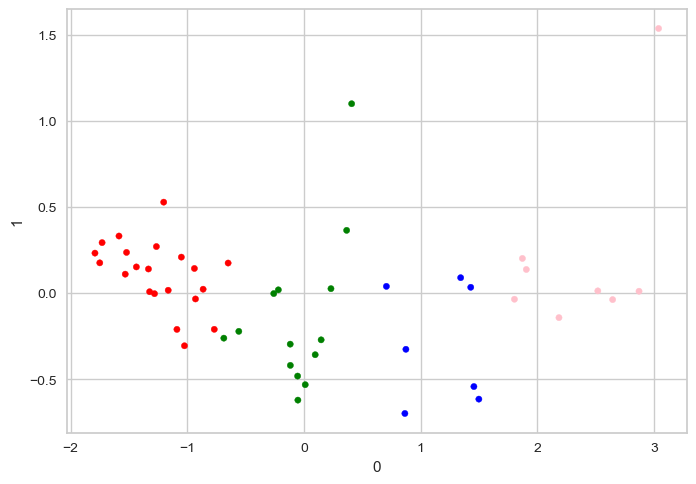

In [197]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(df_degrees_over_career),columns=df_degrees_over_career.columns)
X
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
X_pca = pd.DataFrame(X_pca)
# display(X_pca)
# X_pca.plot.scatter(x=X_pca.columns[0],y=X_pca.columns[1]);
kmeans = KMeans(n_clusters=4).fit(X)

cluster_labels = {}
# Are we doing 1 indexing now?
cluster_labels[3] = kmeans.predict(X)
cluster_labels = pd.DataFrame(cluster_labels)

colorings = {}
# colorings[2] = cluster_labels[2].map({0: "Blue", 1: "Red"}) # This is a new pandas command for us that maps all 0 values to Blue, etc
colorings[3] = cluster_labels[3].map({0: "Blue", 1: "Red",2: "Pink", 3: 'Green'}) # This is a new pandas command for us that maps all 0 values to Blue, etc
# X_pca.plot.scatter(x=X_pca.columns[0],y=X_pca.columns[1],c=colorings[2])
X_pca.plot.scatter(x=X_pca.columns[0],y=X_pca.columns[1],c=colorings[3])

In [198]:
# df = X.reset_index()
df = df_degrees_over_career.reset_index()
df['label'] = cluster_labels[3]
df['label'].value_counts()

1    21
3    14
2     8
0     7
Name: label, dtype: int64

In [199]:
for cluster in sorted(df['label'].unique()):
    print(cluster)
    # display(df[df['label'] == cluster].head())
    display(df[df['label'] == cluster])

0


,Undergraduate Major,Starting Median Salary,Mid-Career Median Salary,label
10,Civil Engineering,53900.0,90500.0,0
14,Construction,53700.0,88900.0,0
17,Economics,50100.0,98600.0,0
22,Finance,47900.0,88300.0,0
35,Management Information Systems (MIS),49200.0,82300.0,0
37,Math,45400.0,92400.0,0
44,Physics,50300.0,97300.0,0


1


,Undergraduate Major,Starting Median Salary,Mid-Career Median Salary,label
3,Anthropology,36800.0,61500.0,1
5,Art History,35800.0,64900.0,1
6,Biology,38800.0,64800.0,1
15,Criminal Justice,35000.0,56300.0,1
16,Drama,35900.0,56900.0,1
18,Education,34900.0,52000.0,1
20,English,38000.0,64700.0,1
21,Film,37900.0,68500.0,1
23,Forestry,39100.0,62600.0,1
24,Geography,41200.0,65500.0,1


2


,Undergraduate Major,Starting Median Salary,Mid-Career Median Salary,label
1,Aerospace Engineering,57700.0,101000.0,2
8,Chemical Engineering,63200.0,107000.0,2
12,Computer Engineering,61400.0,105000.0,2
13,Computer Science,55900.0,95500.0,2
19,Electrical Engineering,60900.0,103000.0,2
30,Industrial Engineering,57700.0,94700.0,2
38,Mechanical Engineering,57900.0,93600.0,2
43,Physician Assistant,74300.0,91700.0,2


3


,Undergraduate Major,Starting Median Salary,Mid-Career Median Salary,label
0,Accounting,46000.0,77100.0,3
2,Agriculture,42600.0,71900.0,3
4,Architecture,41600.0,76800.0,3
7,Business Management,43000.0,72100.0,3
9,Chemistry,42600.0,79900.0,3
11,Communications,38100.0,70000.0,3
25,Geology,43500.0,79500.0,3
28,History,39200.0,71000.0,3
31,Information Technology (IT),49100.0,74800.0,3
33,International Relations,40900.0,80900.0,3


## clustering by whether you can still afford to live in a city 10 years later

In [230]:
df_degrees_over_career = pd.read_csv('degrees-that-pay-back.csv')
df_degrees_over_career = df_degrees_over_career.set_index('Undergraduate Major')
for col in list(df_degrees_over_career):
    if col != 'Percent change from Starting to Mid-Career Salary':
        df_degrees_over_career[col] = df_degrees_over_career[col].str.strip('$')
        df_degrees_over_career[col] = df_degrees_over_career[col].str.replace(',', '')
    df_degrees_over_career[col] = df_degrees_over_career[col].astype(float)

df_degrees_over_career = df_degrees_over_career[['Starting Median Salary', 'Mid-Career Median Salary']]
df_degrees_over_career['starting-med-hourly'] = df_degrees_over_career['Starting Median Salary'] / (40 * 52)
df_degrees_over_career['mid-med-hourly'] = df_degrees_over_career['Mid-Career Median Salary'] / (40 * 52)
display(df_degrees_over_career.count())
df_degrees_over_career.head()

Starting Median Salary      50
Mid-Career Median Salary    50
starting-med-hourly         50
mid-med-hourly              50
dtype: int64

,Starting Median Salary,Mid-Career Median Salary,starting-med-hourly,mid-med-hourly
Undergraduate Major,,,,
Accounting,46000.0,77100.0,22.115385,37.067308
Aerospace Engineering,57700.0,101000.0,27.740385,48.557692
Agriculture,42600.0,71900.0,20.480769,34.567308
Anthropology,36800.0,61500.0,17.692308,29.567308
Architecture,41600.0,76800.0,20.000000,36.923077


In [201]:
combo = cities.merge(df_degrees_over_career.reset_index(), how='cross')
combo = combo[combo['one_adult_no_kids_living_wage'] < combo['starting-med-hourly']]
combo = combo[combo['two_adults_one_working_one_kid_living_wage'] < combo['mid-med-hourly']]
combo.head()

,rank_2020,city,state,population_2020,population_2010,land_area_sqmi,density,one_adult_no_kids_living_wage,one_adult_one_kid_living_wage,one_adult_two_kids_living_wage,...,two_adults_one_working_three_kids_living_wage,two_adults_both_working_no_kids_living_wage,two_adults_both_working_one_kid_living_wage,two_adults_both_working_two_kids_living_wage,two_adults_both_working_three_kids_living_wage,Undergraduate Major,Starting Median Salary,Mid-Career Median Salary,starting-med-hourly,mid-med-hourly
0,1,New York,New York,8804190,8175133,300.5,29298,20.0,38.99,49.18,...,42.42,14.03,20.95,26.53,32.4,Accounting,46000.0,77100.0,22.115385,37.067308
1,1,New York,New York,8804190,8175133,300.5,29298,20.0,38.99,49.18,...,42.42,14.03,20.95,26.53,32.4,Aerospace Engineering,57700.0,101000.0,27.740385,48.557692
2,1,New York,New York,8804190,8175133,300.5,29298,20.0,38.99,49.18,...,42.42,14.03,20.95,26.53,32.4,Agriculture,42600.0,71900.0,20.480769,34.567308
7,1,New York,New York,8804190,8175133,300.5,29298,20.0,38.99,49.18,...,42.42,14.03,20.95,26.53,32.4,Business Management,43000.0,72100.0,20.673077,34.663462
8,1,New York,New York,8804190,8175133,300.5,29298,20.0,38.99,49.18,...,42.42,14.03,20.95,26.53,32.4,Chemical Engineering,63200.0,107000.0,30.384615,51.442308


In [202]:
#combo = combo[['city', 'state', 'population_2020', 'population_2010', 'land_area_sqmi', 'density', 'Undergraduate Major', 'Starting Median Salary', 'Mid-Career Median Salary']]
combo = combo[['city', 'state', 'population_2020', 'population_2010', 'land_area_sqmi', 'density', 'Undergraduate Major', 'one_adult_no_kids_living_wage', 'two_adults_one_working_one_kid_living_wage']]
combo = combo.set_index(['city', 'state', 'Undergraduate Major'])
combo.head()

population_2020  population_2010  \
city     state    Undergraduate Major                                       
New York New York Accounting                     8804190          8175133   
                  Aerospace Engineering          8804190          8175133   
                  Agriculture                    8804190          8175133   
                  Business Management            8804190          8175133   
                  Chemical Engineering           8804190          8175133   

                                         land_area_sqmi  density  \
city     state    Undergraduate Major                              
New York New York Accounting                      300.5    29298   
                  Aerospace Engineering           300.5    29298   
                  Agriculture                     300.5    29298   
                  Business Management             300.5    29298   
                  Chemical Engineering            300.5    29298   

                                         one_adult_no_kids_living_wage  \
city     state    Undergraduate Major                                    
New York New York Accounting                                      20.0   
                  Aerospace Engineering                           20.0   
                  Agriculture                                     20.0   
                  Business Management                             20.0   
                  Chemical Engineering                            20.0   

                                         two_adults_one_working_one_kid_living_wage  
city     state    Undergraduate Major                                                
New York New York Accounting                                                  34.35  
                  Aerospace Engineering                                       34.35  
                  Agriculture                                                 34.35  
                  Business Management                                         34.35  
                  Chemical Engineering                                        34.35

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='PCA Component 0', ylabel='PCA Component 1'>

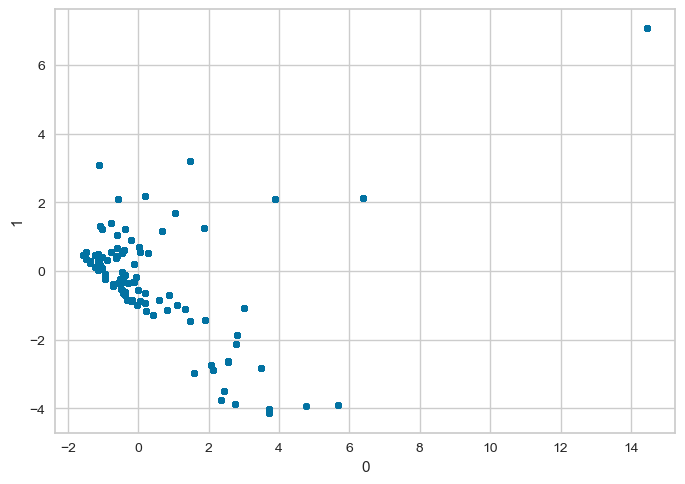

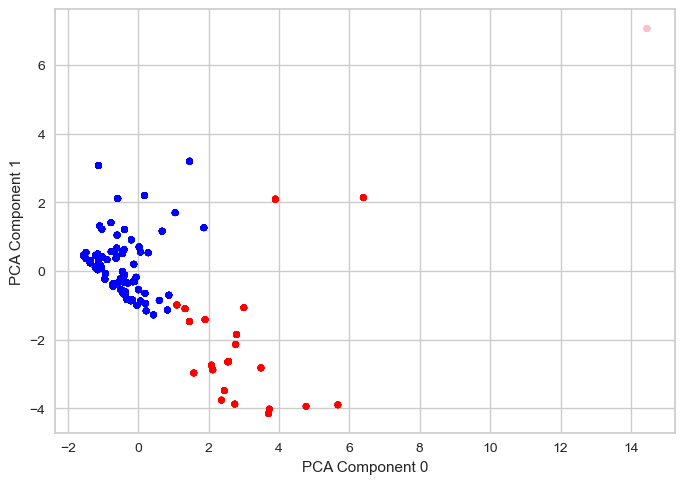

In [203]:

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(combo),columns=combo.columns)
X
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
X_pca = pd.DataFrame(X_pca)
# display(X_pca)
X_pca.plot.scatter(x=X_pca.columns[0],y=X_pca.columns[1]);
kmeans = KMeans(n_clusters=3).fit(X)

cluster_labels = {}
# Are we doing 1 indexing now?
cluster_labels[3] = kmeans.predict(X)
cluster_labels = pd.DataFrame(cluster_labels)

colorings = {}
# colorings[2] = cluster_labels[2].map({0: "Blue", 1: "Red"}) # This is a new pandas command for us that maps all 0 values to Blue, etc
colorings[3] = cluster_labels[3].map({0: "Blue", 1: "Red",2: "Pink", 3: 'Green'}) # This is a new pandas command for us that maps all 0 values to Blue, etc
X_pca.plot.scatter(x=X_pca.columns[0],y=X_pca.columns[1],c=colorings[3], xlabel='PCA Component 0', ylabel='PCA Component 1')

In [184]:
#from sklearn.metrics import silhouette_samples

s_df = pd.DataFrame()

s_df[3] = silhouette_samples(X, cluster_labels[3])
s_df.index.name="i"
s_df = s_df.reset_index()
# display(s_df)
# s_df.sort_values(by=[3]).plot(kind='hist')

source = s_df.melt(id_vars=["i"])
source.columns = ["i","k","s"]
# display(source)

import altair as alt
# alt.renderers.enable('mimetype')
alt.renderers.enable('default')
alt.Chart(source).mark_bar().encode(
    x = "s:Q",
    y = alt.Y("i:N",sort='x',axis=alt.Axis(labels=False)),
    row = "k:N",
    color = "k:N"
).resolve_scale(y='independent').properties(height=200)

# alt.Chart(s.reset_index()).mark_line().encode(
#     x='index:T',
#     y='sil:Q'
# )


/home/claire/.local/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

In [159]:
from sklearn.metrics import silhouette_score
silhouette_score(X, cluster_labels[3])

0.580418638073979

Among the 50 majors

In [232]:
df = combo.reset_index()
df['label'] = cluster_labels[3]
df['label'].value_counts()

for cluster in sorted(df['label'].unique()):
    print(cluster)
    # display(df[df['label'] == cluster].head())
    # display(df[df['label'] == cluster].groupby(['state', 'city'])['label'].value_counts())

    # Get the min wage that all cities in this cluster share (so effectively the maximum wage among the cities)
    # min_wage_df = df[df['label'] == cluster][['city', 'state','one_adult_no_kids_living_wage', 'two_adults_one_working_one_kid_living_wage']].drop_duplicates().sort_values(['one_adult_no_kids_living_wage'],ascending=False)
    # display(min_wage_df.head())
    # min_wage_of_cluster = min_wage_df.head(1)['one_adult_no_kids_living_wage']

    # c = df[df['label'] == cluster][['city', 'state','one_adult_no_kids_living_wage', 'two_adults_one_working_one_kid_living_wage']].drop_duplicates().merge(df_degrees_over_career.reset_index(), how='cross')
    # c = c[c['one_adult_no_kids_living_wage'] < c['starting-med-hourly']]
    # c = c[c['two_adults_one_working_one_kid_living_wage'] < c['mid-med-hourly']]

    sets = df[df['label'] == cluster].groupby(['state', 'city'])['Undergraduate Major'].apply(set)
    # display(list(sets))

    # cols_set = list(df.apply(lambda col: set(col.values)).values)
    output = list(set.intersection(*(list(sets))))
    print("Number of majors:", len(output))
    display(pd.Series(output))



0
Number of majors: 28


['Communications',
 'Chemical Engineering',
 'Business Management',
 'Architecture',
 'Political Science',
 'Chemistry',
 'Construction',
 'Marketing',
 'Mechanical Engineering',
 'Electrical Engineering',
 'International Relations',
 'Computer Science',
 'Economics',
 'Math',
 'Accounting',
 'Management Information Systems (MIS)',
 'Philosophy',
 'Physician Assistant',
 'Industrial Engineering',
 'Aerospace Engineering',
 'Civil Engineering',
 'Agriculture',
 'Physics',
 'Geology',
 'History',
 'Finance',
 'Computer Engineering',
 'Information Technology (IT)']

1
Number of majors: 7


['Aerospace Engineering',
 'Chemical Engineering',
 'Mechanical Engineering',
 'Electrical Engineering',
 'Computer Science',
 'Industrial Engineering',
 'Computer Engineering']

2
Number of majors: 21


['Economics',
 'Math',
 'Chemical Engineering',
 'Accounting',
 'Management Information Systems (MIS)',
 'Physician Assistant',
 'Industrial Engineering',
 'Business Management',
 'Computer Engineering',
 'Chemistry',
 'Aerospace Engineering',
 'Agriculture',
 'Construction',
 'Mechanical Engineering',
 'Electrical Engineering',
 'Physics',
 'Geology',
 'Computer Science',
 'Finance',
 'Civil Engineering',
 'Information Technology (IT)']